# skorch doctor

Use tips from Andrej Karpathy on how to better understand the neural net and diagnose potential errors.

Sources:

- https://karpathy.github.io/2019/04/25/recipe/
- https://www.youtube.com/watch?v=P6sfmUTpUmc
    
The `SkorchDoctor` class tries to automate as much as possible from those tips.

## Imports

In [1]:
from functools import partial
from itertools import islice

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
from skorch import NeuralNetClassifier
from skorch.utils import to_numpy
from skorch.callbacks import Callback

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## New code

In [5]:
def add_activation_hooks(net):
    activations = {}
    handles = []
    def activation_hook(model, input, output, *, name):
        activations[name] = to_numpy(output)

    for module_name in net._modules + net._criteria:
        module = getattr(net, module_name + '_')
        if not isinstance(module, torch.nn.Module):
            continue

        handle = module.register_forward_hook(partial(activation_hook, name=module_name.upper()))
        handles.append(handle)

        for name, submodule in module.named_modules():
            if submodule is module:
                continue

            handle = submodule.register_forward_hook(partial(activation_hook, name=name))
            handles.append(handle)

    return activations, handles

In [6]:
def add_grad_hooks(net):
    grads = {}
    handles = []
    def grad_hook(grad, *, name):
        grads[name] = to_numpy(grad)

    for module_name in net._modules + net._criteria:
        module = getattr(net, module_name + '_')
        if not isinstance(module, torch.nn.Module):
            continue

        for name, tensor in module.named_parameters():
            if tensor.requires_grad:
                handle = tensor.register_hook(partial(grad_hook, name=name))
                handles.append(handle)

    return grads, handles

In [7]:
class LogActivationsGradients(Callback):
    def __init__(
        self,
        activation_logs,
        gradient_logs,
        param_update_logs,
        activations,
        gradients
    ):
        self.activation_logs = activation_logs
        self.gradient_logs = gradient_logs
        self.param_update_logs = param_update_logs
        self.activations = activations
        self.gradients = gradients
        
    def on_epoch_begin(self, net, **kwargs):
        self.activation_logs.append([])
        self.gradient_logs.append([])
        self.param_update_logs.append([])

    def on_batch_end(self, net, batch=None, training=False, **kwargs):
        if not training:
            return

        update = {}
        for key, param in net.get_all_learnable_params():
            grad = self.gradients[key]
            update[key] = (grad.std() / param.std()).item()
        self.param_update_logs[-1].append(update)

        breakpoint()
        self.activation_logs[-1].append(self.activations.copy())
        self.activations.clear()
        self.gradient_logs[-1].append(self.gradients.copy())
        self.gradients.clear()

        return self

In [8]:
def flatten(items):
    for item in items:
        if isinstance(item, (list, tuple)):
            yield from flatten(item)
        else:
            yield item

In [9]:
class SkorchDoctor:
    def __init__(self, net):
        self.net = net
        
    def add_callback(self, net, name, callback):
        if net.callbacks is None:
            net.callbacks = [(name, callback)]
        else:
            net.callbacks.append((name, callback))
        net.initialize_callbacks()

    def initialize(self):
        self.fitted = False
        self.handles_ = []
        self.activation_logs_ = []
        self.gradient_logs_ = []
        self.param_update_logs_ = []

        if not net.initialized_:
            self.net.initialize()

        activations, ahandles = add_activation_hooks(net)
        self.activations_ = activations
        self.handles_.extend(ahandles)

        gradients, ghandles = add_grad_hooks(net)
        self.gradients_ = gradients
        self.handles_.extend(ghandles)

        cb = LogActivationsGradients(
            activation_logs=self.activation_logs_,
            gradient_logs=self.gradient_logs_,
            param_update_logs=self.param_update_logs_,
            activations=self.activations_,
            gradients=self.gradients_,
        )
        self.add_callback(self.net, 'log_activations_gradients', cb)
        return self

    def remove_callback(self, net, callback_name):
        indices = []
        for i, callback in enumerate(net.callbacks):
            if not isinstance(callback, tuple):
                continue
            name, _ = callback
            if name == callback_name:
                indices.append(i)

        for i in indices[::-1]:
            del net.callbacks[i]

        indices = []
        for i, (name, _) in enumerate(net.callbacks_):
            if name == callback_name:
                indices.append(i)
             
        for i in indices[::-1]:
            del net.callbacks_[i]

    def clean_up(self):
        for handle in self.handles_:
            handle.remove()

        #self.remove_callback(net, 'param_update')
        self.remove_callback(net, 'log_activations_gradients')

    # TODO: not used
    def ___make_report(self):
        # only training related data, not valid
        rows = []
        history = self.net.history

        for epoch in range(len(history)):
            epoch_activations = self.activation_logs_[epoch]
            epoch_gradients = self.gradient_logs_[epoch]
            epoch_params_updates = self.param_update_logs_[epoch]

            for batch in range(len(epoch_activations)):
                batch_activations = epoch_activations[batch]
                batch_gradients = epoch_gradients[batch]
                batch_param_updates = epoch_params_updates[batch]

                row = {
                    # start counting at 1
                    'epoch': epoch + 1,
                    'batch': batch + 1,
                    'train_batch_size': history[epoch, 'batches', batch, 'train_batch_size'],
                }

                for module_name, val in batch_activations.items():
                    row[f'mean_abs_activity_{module_name}'] = np.abs(val).mean()

                for param_name, val in batch_gradients.items():
                    row[f'mean_abs_gradient_{param_name}'] = np.abs(val).mean()

                for param_name, val in batch_param_updates.items():
                    row[f'mean_relative_param_update_{param_name}'] = val

                rows.append(row)

        df = pd.DataFrame(rows)
        return df

    # TODO: not used
    def ___aggregate_batch_report(self, df):
        """Aggregate from batch level to epoch level"""
        def reduce_epoch(dfg):
            keys = [key for key in dfg if key.startswith('mean')]
            batch_sizes = dfg['train_batch_size'].values
            aggregated = {key: np.average(dfg[key].values, weights=batch_sizes) for key in keys}
            return aggregated

        df_agg = df.groupby('epoch').apply(reduce_epoch)
        df_agg = pd.DataFrame([df_agg.values[i] for i in range(len(df_agg))])
        return df_agg

    def fit(self, X, y):
        self.initialize()
        try:
            self.net.partial_fit(X, y)
        finally:
            self.clean_up()

        # The idea here is to have something similar to cv_results_, but not sure if it's useful
        # self.report_batch_ = self.make_report()
        # self.report_epoch_ = self.aggregate_batch_report(self.report_batch_)
        self.num_steps_ = sum(1 for _ in flatten(self.activation_logs_))

        self.fitted_ = True
        return self
    
    def plot_loss(self, ax=None, **kwargs):
        assert self.fitted_
        
        ax = ax or plt.subplots()[1]
        history = self.net.history
        xvec = np.arange(len(history)) + 1
        ax.plot(xvec, history[:, 'train_loss'], label='train')
        
        if 'valid_loss' in history[0]:
            ax.plot(xvec, history[:, 'valid_loss'], label='valid', **kwargs)
            
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
        ax.set_title('loss over time')
        return ax
    
    def plot_activations(self, step=-1, ax=None, histtype='step', lw=2, bins=None, density=True, **kwargs):
        assert self.fitted_
        
        ax = ax or plt.subplots()[1]
        activations = list(flatten(self.activation_logs_))[step]
        if bins is None:
            bin_min = min(a.min() for a in activations.values())
            bin_max = max(a.max() for a in activations.values())
            bins = np.linspace(bin_min, bin_max, 30)

        for key, val in activations.items():
            if val.ndim:
                ax.hist(val.flatten(), label=key, histtype=histtype, lw=lw, bins=bins, density=density, **kwargs)
        ax.legend()
        ax.set_title("distribution of activations")
        return ax
    
    def plot_gradients(self, step=-1, ax=None, histtype='step', lw=2, bins=None, density=True, **kwargs):
        assert self.fitted_
        
        ax = ax or plt.subplots()[1]
        gradients = list(flatten(self.gradient_logs_))[step]
        if bins is None:
            bin_min = min(g.min() for g in gradients.values())
            bin_max = max(g.max() for g in gradients.values())
            bins = np.linspace(bin_min, bin_max, 30)

        for key, val in gradients.items():
            if val.ndim:
                ax.hist(val.flatten(), label=key, histtype="step", lw=2, bins=bins, density=True, **kwargs)
        ax.legend()
        ax.set_title("distribution of gradients")
        return ax

    def plot_param_updates(self, ax=None, **kwargs):
        assert self.fitted_

        ax = ax or plt.subplots()[1]
        param_updates = list(flatten(self.param_update_logs_))
        keys = param_updates[0].keys()
        
        for key in keys:
            values = [np.log10(update[key]) for update in param_updates]
            xvec = np.arange(1, len(values) + 1)
            ax.plot(xvec, values, label=key)
        ax.set_xlabel("step")
        ax.set_ylabel("log10 of stdev of relative parameter updates")
        ax.legend()
        
        return ax

### A toy binary classification task

We load a toy classification task from `sklearn`.

In [10]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)

In [11]:
X.shape, y.shape, y.mean()

((1000, 20), (1000,), 0.5)

### Definition of the `pytorch` classification `module`

In [12]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, self.num_units)
        self.nonlin = self.nonlin
        self.dropout = nn.Dropout(self.dropout)
        self.dense1 = nn.Linear(self.num_units, self.num_units)
        self.output = nn.Linear(self.num_units, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [13]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=5,
    lr=0.1,
    batch_size=64,
)

## Use skorch doctor

### Train the doctor first

It's sufficient to use a small amount of data

In [14]:
doctor = SkorchDoctor(net)

In [15]:
doctor.fit(X[:100], y[:100])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6913       0.6000        0.6635  0.0127
      2        0.6642       0.5500        0.6603  0.0053
      3        0.6834       0.6000        0.6589  0.0054
      4        0.6783       0.7000        0.6556  0.0072
      5        0.6499       0.6500        0.6588  0.0069


### Inspect data

For each epoch and each batch, store the activations, gradients, and parameter updates. The data is thus stored in lists (epochs) of lists (batches) of dictionaries (module/parameter names).

#### example: activations

Example: Get the mean abs activation of each layer in the batch of the first epoch. `MODULE` and `CRITIERION` correspond to the `net.module_` and `net.criterion_`.

In [16]:
for key, val in doctor.activation_logs_[0][-1].items():
    print(f"mean activation of layer {key:<9}: {np.abs(val).mean():.4f}")

mean activation of layer dense0   : 0.9948
mean activation of layer dropout  : 0.5156
mean activation of layer dense1   : 0.5101
mean activation of layer output   : 0.1840
mean activation of layer MODULE   : 0.5000
mean activation of layer CRITERION: 0.7232


#### example: gradients

Example: Get the mean abs gradient of each parameter from the first batch of the second epoch.

In [17]:
for key, val in doctor.gradient_logs_[1][0].items():
    print(f"mean activation of layer {key:<14}: {np.abs(val).mean():.4f}")

mean activation of layer output.bias   : 0.0753
mean activation of layer output.weight : 0.0212
mean activation of layer dense1.bias   : 0.0128
mean activation of layer dense1.weight : 0.0093
mean activation of layer dense0.bias   : 0.0066
mean activation of layer dense0.weight : 0.0082


### Plot train and validation loss

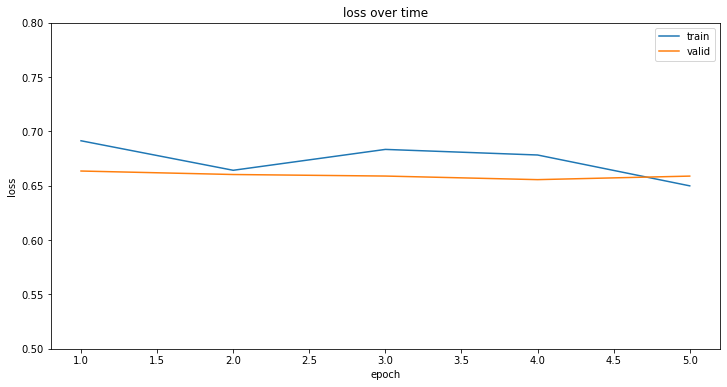

In [18]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax)
ax.set_ylim([0.5, 0.8]);

### Plot distribution of activations of each layer

#### first step

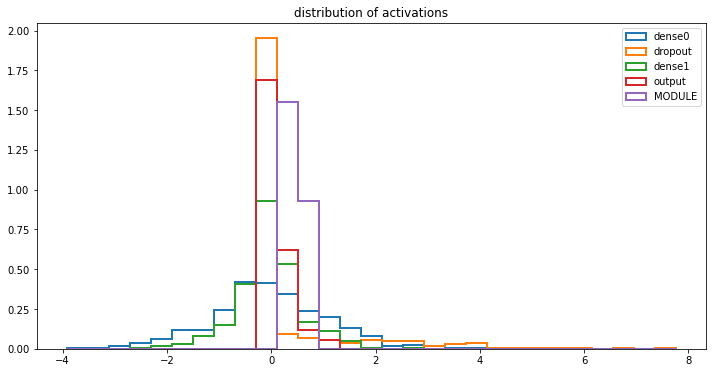

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_activations(ax=ax, step=0);

#### last step (default)

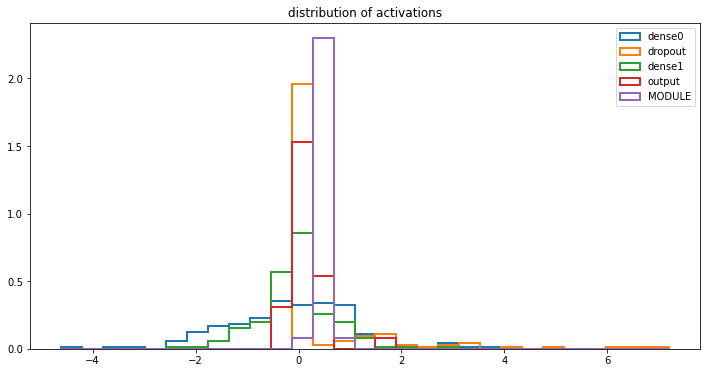

In [20]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_activations(ax=ax);

### Show gradients of each parameter

#### first step

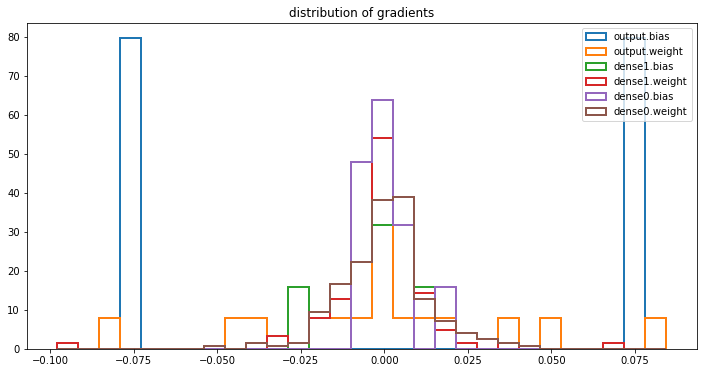

In [21]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_gradients(ax=ax, step=0);

#### last step (default)

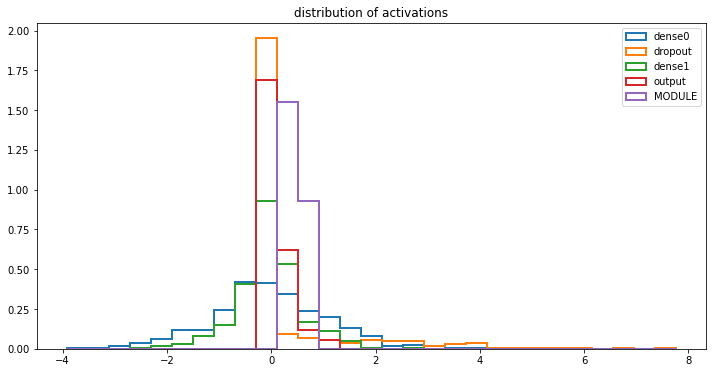

In [22]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_activations(ax=ax, step=0);

### Show parameter updates over time

See https://youtu.be/P6sfmUTpUmc?t=5995

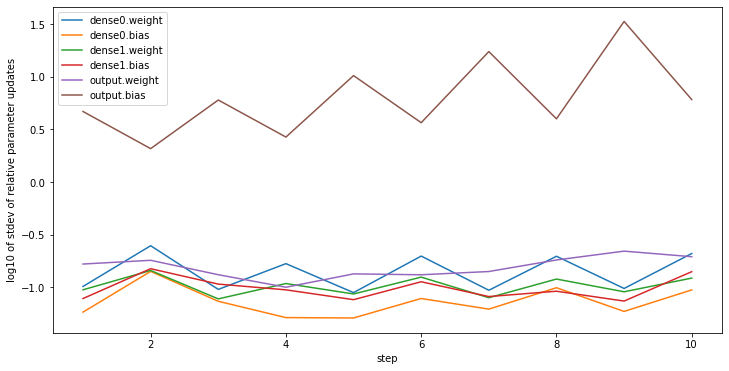

In [23]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_param_updates(ax=ax);